# Survival analysis

Make a dictionary where we have a table for each cancer type that's ready to plug into the plotter. Format: One column of days until last contact or death (duration col), on column of vital status (event col), and a column of true/false for each event (attribute).

Then plot for each cancer type.

In [1]:
import pandas as pd
import numpy as np
import cptac
import cptac.utils as ut
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

## Prepare tables

In [2]:
plot_tables = {}

dss = {
#     "brca": cptac.Brca,
#     "colon": cptac.Colon,
    "hnscc": cptac.Hnscc,
#     "lscc": cptac.Lscc,
    "luad": cptac.Luad,
    "ovarian": cptac.Ovarian
}

In [3]:
def prepare_plot_table(ds):
    
    # Load the followup data
    ds = ds()
    cancer_type = ds.get_cancer_type()
    
    if cancer_type in ["ovarian"]:
        fp = ds.get_clinical()
    else:
        fp = ds.get_followup()
    
    cancer_col_names = {
        "brca": {
            
        },
        "colon": {
            
        },
        "hnscc": {
            "vital_status": "VITAL_STATUS",
            "last_contact": "PATHO_DIAG_TO_LAST_CONT_DAYS",
            "death": "PATHO_DIAG_TO_DEATH_DAYS",
        },
#         "lscc": { # No followup data for LSCC :(
            
#         },
        "luad": {
            "vital_status": "Vital Status",
            "last_contact": "Path Diag to Last Contact(Day)",
            "death": "Path Diag to Death(days)",
        },
        "ovarian": {
            "vital_status": "Vital_Status",
            "last_contact": "Days_Between_Collection_And_Last_Contact",
            "death": "Days_Between_Collection_And_Death"
        }
    }
    
    vital_status_col = cancer_col_names[cancer_type]["vital_status"]
    last_contact_col = cancer_col_names[cancer_type]["last_contact"]
    death_col = cancer_col_names[cancer_type]["death"]
    
    # Rename columns for consistency
    fp = fp[[vital_status_col, last_contact_col, death_col]].\
    rename(columns={
        vital_status_col: "vital_status",
        last_contact_col: "days_to_last_contact",
        death_col: "days_to_death"
    }).\
    dropna(axis="index", how="all")

    # Take care of multiple entries for each patient
    fp = fp.groupby("Patient_ID").agg(
        death=("vital_status", min), # This will select Deceased over Living
        days_to_last_contact=("days_to_last_contact", max),
        days_to_death=("days_to_death", max)
    )
    
    # Fill NaNs in days_to_last_contact and days_to_death columns
    fp["days_to_last_contact"] = fp["days_to_last_contact"].fillna(fp["days_to_death"])
    fp["days_to_death"] = fp["days_to_death"].fillna(fp["days_to_last_contact"])
    
    # Combine the days until last contact and days until death columns
    fp = fp.assign(days_to_last_contact_or_death=fp["days_to_last_contact"].combine(fp["days_to_death"], max))
    
    # Drop the other two
    fp = fp.drop(columns=["days_to_last_contact", "days_to_death"])
    
    # Fill vals
    fp["death"] = fp["death"].replace({"Deceased": True, "Living": False})
    
    # Load the CNV event table
    event = pd.read_csv(f"{cancer_type}_has_event.tsv", sep="\t", index_col=0).\
    rename(columns={
        "gain_event": "8q_gain",
        "loss_event": "8p_loss"
    })
    
    # Join the two
    joined = fp.join(event, how="inner")
    
    # Drop any NaN rows
    joined = joined.dropna(axis="index", how="any")
    
    # Check
    assert joined.index.duplicated().sum() == 0
    
    return joined

In [4]:
def plot_multivar_survival(cancer_type, df, cnv_col):
    
    cph = CoxPHFitter()
    cph.fit(
        df=df, 
        duration_col="days_to_last_contact_or_death",
        event_col="death"
    )
    
    deceased_count = df["death"].sum()
    living_count = df["death"].size - deceased_count
    
    plot_title = f"{cancer_type} survival: {cnv_col}\n{deceased_count} deceased, {living_count} living"
    
    return cph.plot_partial_effects_on_outcome(
        covariates=cnv_col, 
        values=[False, True],
        plot_baseline=True,
        cmap='coolwarm', 
        title=plot_title
    )

cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (/home/caleb/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 4)


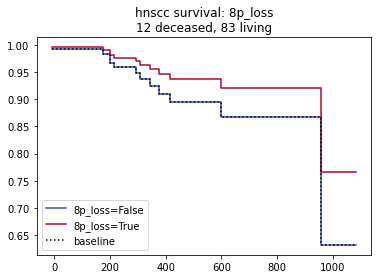

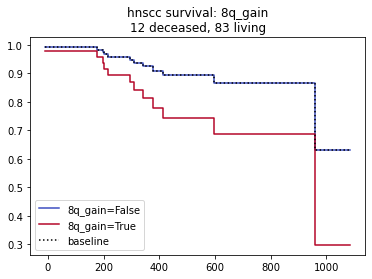

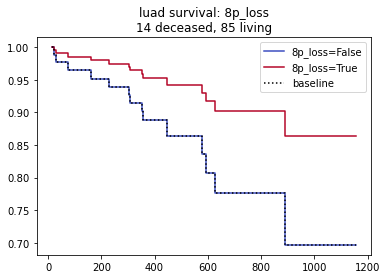

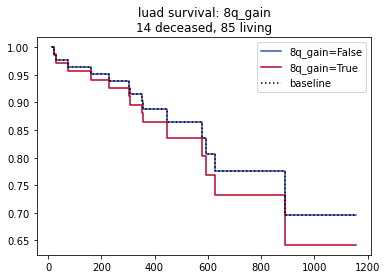

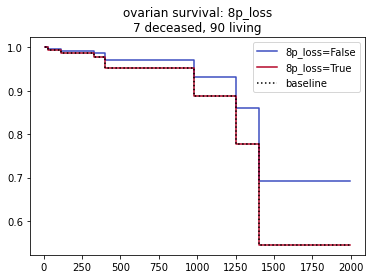

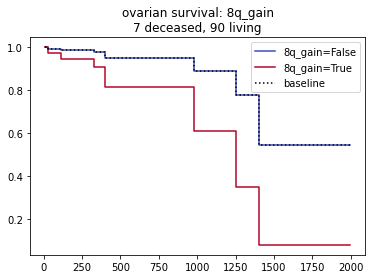

In [5]:
for cancer_type, ds in dss.items():
    df = prepare_plot_table(ds)
    for cnv_col in ["8p_loss", "8q_gain"]:
        plot_multivar_survival(cancer_type, df, cnv_col)

In [6]:
br = cptac.Brca()

In [7]:
co = cptac.Colon()

In [9]:
pd.options.display.max_columns = None

In [10]:
br.get_followup()

Name,Short Title,Event,Modified Time,Modified By,Status,CRF Name,Date of Last Contact,Vital Status (at time of last contact),Date of Death,Tumor Status (at time of last contact or death),Was a Review of the Initial Pathological Findings Done?,Was the Pathology Review consistent with the Diagnosis?,OE_Margin Status after Surgical Procedure,"OE_If margins were positive after first surgical resection, what was the surgical procedure performed to achieve negative margins?",OE_Other Surgical Method Performed to Achieve Negative Margins,OE_Margin Status after second surgical resection,OE_Adjuvant (Post-Operative) Clinical Trial Medication Therapy,OE_Adjuvant (Post-Operative) HER2 Targeted Therapy,OE_New Tumor Event After Initial Treatment?,OE_Type of New Tumor Event,OE_Anatomic Site of New Tumor Event,OE_Other Site of New Tumor Event,OE_Date of New Tumor Event,OE_Additional treatment for New Tumor Event: Surgery,OE_Date of Additional Surgery for New Tumor Event,OE_Additional treatment for New Tumor Event: Radiation Therapy,OE_Additional treatment for New Tumor Event: Pharmaceutical Therapy,OE_Site of First Non-Nodal Metastatic Tumor,OE_Other Site of First Non-Nodal Metastatic Tumor,"Was neoadjuvant systemic treatment given after collection of samples for CPTAC, before the first surgical procedure",First Surgical Procedure,Other First Surgical Procedure,Margin Status after First Surgical Procedure,"If margins were positive after first surgical resection, what was the surgical procedure performed to achieve negative margins?",Other Surgical Method Performed to Achieve Negative,Margin Status after second surgical resection,Adjuvant (Post-Operative) Radiation Therapy,Adjuvant (Post-Operative) Chemotherapy,Adjuvant (Post-Operative) Endocrine Therapy,Adjuvant (Post-Operative) Clinical Trial Medication Therapy,Adjuvant (Post-Operative) Clinical Trial ID,Adjuvant (Post-Operative) HER2 Targeted Therapy,New Tumor Event After Initial Treatment?,Type of New Tumor Event,Anatomic Site of New Tumor Event,Other Site of New Tumor Event,Date of New Tumor Event,Additional treatment for New Tumor Event: Surgery,Date of Additional Surgery for New Tumor Event,Additional treatment for New Tumor Event: Radiation Therapy,Additional treatment for New Tumor Event: Pharmaceutical Therapy,Site of First Non-Nodal Metastatic Tumor,Other Site of First Non-Nodal Metastatic Tumor,Radiation Type,Location of Radiation Treatment,Number of Days from Date of Initial Pathologic Diagnosis to the Date Radiation Therapy Started,Total Dose,Units,Total Number of Fractions,Radiation Treatment Ongoing,Number of Days from Date of Initial Pathologic Diagnosis to the Date Radiation Therapy Ended,Measure of Best Response of Radiation Treatment,Was Patient Treated on a Clinical Trial?,Drug Name (Brand or Generic),Clinical Trial Drug Classification,Pharmaceutical Type,Number of Days from Date of Initial Pathologic Diagnosis to Date of Therapy Start,Therapy Ongoing,Number of Days from Date of Initial Pathologic Diagnosis to Date of Therapy End,Measure of Best Response of Pharmaceutical Treatment,What Type of Malignancy was This?,Primary Site of Disease,Laterality of the Disease,Histological Type,Number of Days from Date of Initial Pathologic Diagnosis of the Tumor Submitted for CPTAC to the Date of Initial Diagnosis of Other Malignancy,Did the patient have surgery for this malignancy?,Type of Surgery,Number of Days from Date of Initial Pathologic Diagnosis of the Tumor Submitted for CPTAC to the Date of Surgical Resection for this Other Malignancy,Did the patient receive pharmaceutical therapy for this malignancy?,Extent of Pharmaceutical Therapy,Drug Name(s) (Brand or Generic),Number of Days from Date of Initial Pathologic Diagnosis of the Tumor Submitted for CPTAC to Date Pharmaceutical Therapy Started for this Other Malignancy,Did the patient receive radiation therapy for this malignancy,Extent of Radiation Therapy,"If the patient received locoregional radiation, was the radiation t

In [11]:
co.get_followup()

Name,Short Title,Event,Modified Time,Modified By,Status,CRF Name,Date of Last Contact (Do not answer if patient is deceased),Vital Status (at time of last contact),Date of Death,Tumor Status (at time of last contact or death),Was a Review of the Initial Pathological Findings Done?,Was the Pathology Review consistent with the Diagnosis?,Adjuvant Post-Operative Radiation Therapy,Adjuvant Post-Operative Pharmaceutical Therapy,Adjuvant Post-Operative Targeted Molecular Therapy,New Tumor Event After Initial Treatment,Method Of Diagnosis of New Tumor Event,Other Method Of Diagnosis of New Tumor Event,"If No New Tumor Event, explain how it was confirmed.",Type of New Tumor Event,Anatomic Site of New Tumor Event,Other Site of New Tumor Event,Date of New Tumor Event After Initial Treatment,Additional Surgery for New Tumor Event,Date of of Additional Surgery for New Tumor Event,Residual Tumor after surgery for New Tumor Event (AJCC 7th Edition),Additional Radiation Therapy Treatment of New Tumor Event,Additional Pharmaceutical Therapy Treatment of New Tumor Event,Additional Targeted Molecular Therapy Treatment of New Tumor Event,Radiation Type,Location of Radiation Treatment,Number of Days from Date of Initial Pathologic Diagnosis to the Date Radiation Therapy Started,Total Dose,Units,Total Number of Fractions,Radiation Treatment Ongoing,Number of Days from Date of Initial Pathologic Diagnosis to the Date Radiation Therapy Ended,Measure of Best Response of Radiation Treatment,Was Patient Treated on a Clinical Trial?,Drug Name (Brand or Generic),Clinical Trial Drug Classification,Pharmaceutical Type,Number of Days from Date of Initial Pathologic Diagnosis to Date of Therapy Start,Therapy Ongoing,Number of Days from Date of Initial Pathologic Diagnosis to Date of Therapy End,Measure of Best Response of Pharmaceutical Treatment,What Type of Malignancy was This?,Primary Site of Disease,Laterality of the Disease,Histological Type,Number of Days from Date of Initial Pathologic Diagnosis of the Tumor Submitted for CPTAC to the Date of Initial Diagnosis of Other Malignancy,Did the patient have surgery for this malignancy?,Type of Surgery,Number of Days from Date of Initial Pathologic Diagnosis of the Tumor Submitted for CPTAC to the Date of Surgical Resection for this Other Malignancy,Did the patient receive pharmaceutical therapy for this malignancy?,Extent of Pharmaceutical Therapy,Drug Name(s) (Brand or Generic),Number of Days from Date of Initial Pathologic Diagnosis of the Tumor Submitted for CPTAC to Date Pharmaceutical Therapy Started for this Other Malignancy,Did the patient receive radiation therapy for this malignancy?,Extent of Radiation Therapy,"If the patient received locoregional radiation, was the radiation therapy received in the same field as the tumor submitted for CPTAC?",Number of Days from Date of Initial Pathologic Diagnosis of the Tumor Submitted to CPTAC to Date Radiation Therapy Started for this Other Malignancy,Was the patient staged using FIGO?,FIGO Staging System (Gynecologic Tumors Only),FIGO Stage,Was the patient staged using AJCC?,AJCC Cancer Staging Edition,Pathologic Spread: Primary Tumor (pT),Pathologic Spread: Lymph Nodes (pN),Distant Metastases (M),AJCC Tumor Stage
Patient_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01CO001,CPTAC-WU-01CO,Collection,2016-03-21,"Khandekar, Divya",Locked,One Year,2015-04-28,Living,NaT,Tumor free,No,NaN,No,Yes,Yes,No,NaN,NaN,Colonoscopy,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01CO005,CPTAC-WU-01CO,Collection,2016-03-21,"Khandekar, Divya",Locked,One Year,NaT,Deceased,2015-10-25,Tumor free,No,NaN,No,Yes,No,No,NaN,NaN,CT Scan,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N